In [1]:
from init import *

# 1-factor HullWhite Model
With constant $\alpha$, $\theta$ and $\sigma$.

In [2]:
def create_model (alpha,theta,sigma,r0=0,t0=0,TimeSteps=2,NumPaths=1000):
    print(f'HW(alpha={alpha},theta={theta},sigma={sigma}) model with {TimeSteps} time steps and {NumPaths} paths.')

    model = sdk.Model()
    model.TimeStart = t0
    model.TimeSteps = TimeSteps
    model.NumPaths = NumPaths
    model.Add(sdk.IndependentGaussian())
    
    model.alpha = alpha
    model.theta = theta
    model.sigma = sigma
    model.r0    = r0
    
    model.hw_uf = model.Add(sdk.Updater('HullWhite1FactorModel',args=[alpha,theta,sigma],start=[0],title='rate'))
    model.df_uf = model.Add(sdk.ZeroCouponBond(underlying=model.hw_uf.GetStateNumber(),start=1,title=f'df'))
    
    return model

## Theoretical Rate Distribution in HullWhite model
See https://en.wikipedia.org/wiki/Hull%E2%80%93White_model

In [3]:
from math import *
def theoretical_rate(model,t):
    z = exp(-model.alpha*t)
    mean  = z*model.r0 + model.theta/model.alpha*(1-z)
    sigma = sqrt(model.sigma**2/(2*model.alpha)*(1-z**2))
    return (mean,sigma)

In [4]:
model = create_model(0.01,0.02,0.03,TimeSteps=100,NumPaths=1000000)
TimeHorizon = 10
for t in [model.TimeStart,TimeHorizon]:
    model.evaluations.append(sdk.EvaluationPoint(t)
        .Add(sdk.Histogram(
            ax = sdk.HistogramAxis(
                model.hw_uf.GetStateNumber(),
                200
            ),
        ))
        .Add(sdk.Histogram(
            ax = sdk.HistogramAxis(
                model.df_uf.GetStateNumber(),
                200,0,2
            ),
        ))
    )
results = sdk.run (model, server)
results.df()

HW(alpha=0.01,theta=0.02,sigma=0.03) model with 100 time steps and 1000000 paths.


,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,HullWhite1FactorModel,rate,0,0.0,-1,1000000,0.000000,0.000000,0.000000,NaN
1,ZeroCouponBond,df,1,0.0,-1,1000000,1.000000,0.000000,0.000000,NaN
2,HullWhite1FactorModel,rate,0,10.0,99,1000000,0.190541,0.000090,0.090276,0.000803
3,ZeroCouponBond,df,1,10.0,99,1000000,0.437246,0.000248,0.247880,1.850343


In [5]:
theory_mean, theory_sigma = theoretical_rate(model,10)

# Compare Theorical and MonteCarlo Results

In [6]:
import pandas as pd
pd.DataFrame([{
    'Method':'Theory',
    'mean':theory_mean,
    'sigma':theory_sigma
},{
    'Method':'MonteCarlo',
    'mean':results.GetStateEvaluationResult(model.hw_uf.GetStateNumber(),1).mean,
    'sigma':results.GetStateEvaluationResult(model.hw_uf.GetStateNumber(),1).stddev
}])

,Method,mean,sigma
0,Theory,0.190325,0.090317
1,MonteCarlo,0.190541,0.090276


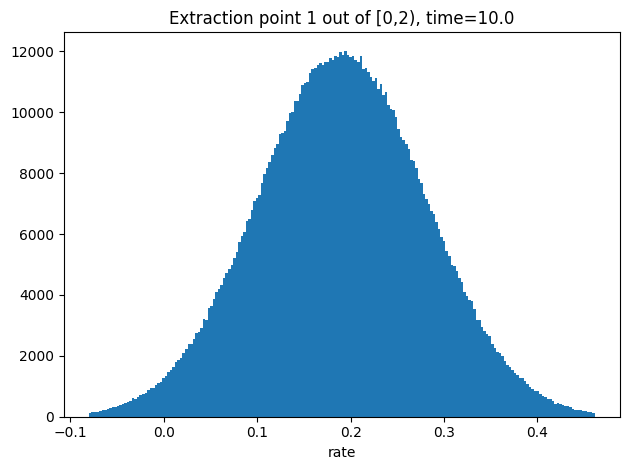

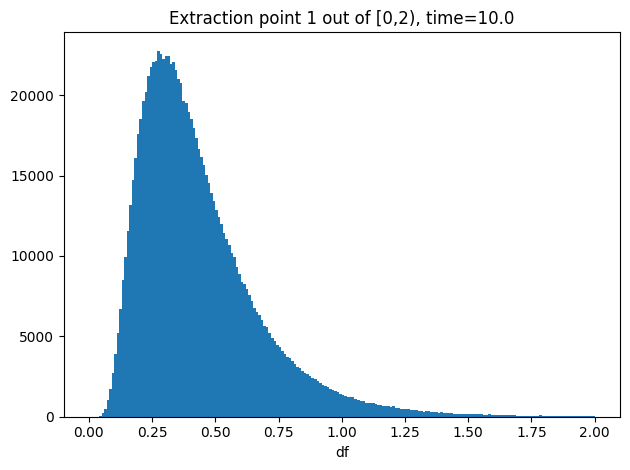

In [7]:
plot(results=results,point=1,stateX=model.hw_uf.GetStateNumber())
plot(results=results,point=1,stateX=model.df_uf.GetStateNumber())